<a href="https://colab.research.google.com/github/aolivieri/colon/blob/master/colon_colonoscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls 

colon_colonoscopy.h5	    colon_histological.h5     Kvasir
colon_colonoscopy.ipynb     colon_histological.ipynb  preprocess_crop.py
colon_colonoscopy_v2.ipynb  colon_image_sets	      README.md


In [1]:
# Importing the libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.regularizers import l2
tf.__version__

'2.3.1'

In [2]:
import tensorflow.keras.backend as K

In [33]:
# K.clear_session()

In [3]:
# Part 1 - Data Preprocessing

# Generating images for the Training set
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Generating images for the Test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Creating the Training set
training_set = train_datagen.flow_from_directory('./Kvasir/kvasir-dataset-v2', 
                                                 target_size = (224, 224),
                                                 subset='training')

# Creating the Validation set
validation_set = train_datagen.flow_from_directory('./Kvasir/kvasir-dataset-v2',
                                                   target_size = (224, 224),
                                                   subset='validation')

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [4]:
a, b = training_set.next()
a.shape, b.shape

((32, 224, 224, 3), (32, 8))

In [5]:
from PIL import Image
import numpy as np

[0. 0. 1. 0. 0. 0. 0. 0.]


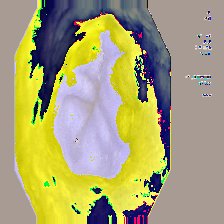

In [6]:
print(b[0])
Image.fromarray(np.uint8(a[0]))

[0. 1. 0. 0. 0. 0. 0. 0.]


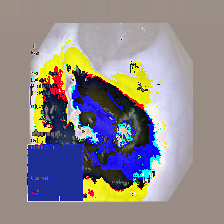

In [7]:
print(b[2])
Image.fromarray(np.uint8(a[2]))

In [8]:
from collections import Counter
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [12]:
# Transfer Learning

from tensorflow.keras.models import *

pretrained_nn = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Freeze all layers
for l in pretrained_nn.layers:
  l.trainable = False

global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(pretrained_nn.output)
fc1 = tf.keras.layers.Dense(512, activation='relu')(global_avg_pool)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
output = tf.keras.layers.Dense(8, activation='softmax')(fc2)

model = Model(pretrained_nn.input, output)

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
# Training
from keras import callbacks
hist = model.fit(training_set,
                  steps_per_epoch = training_set.__len__(),
                  epochs = 50,
                  validation_data = validation_set,
                  validation_steps = validation_set.__len__(),
                  callbacks=[callbacks.ModelCheckpoint('cp-model.h5', save_best_only=True)])

Epoch 1/50
200/200 [==============================] - 127s 635ms/step - loss: 0.7017 - accuracy: 0.7450 - val_loss: 0.4559 - val_accuracy: 0.8313
Epoch 2/50
200/200 [==============================] - 119s 597ms/step - loss: 0.3713 - accuracy: 0.8594 - val_loss: 0.3958 - val_accuracy: 0.8462
Epoch 3/50
200/200 [==============================] - 119s 596ms/step - loss: 0.3275 - accuracy: 0.8742 - val_loss: 0.3735 - val_accuracy: 0.8512
Epoch 4/50
200/200 [==============================] - 119s 594ms/step - loss: 0.2982 - accuracy: 0.8838 - val_loss: 0.3765 - val_accuracy: 0.8456
Epoch 5/50
200/200 [==============================] - 119s 595ms/step - loss: 0.2865 - accuracy: 0.8858 - val_loss: 0.3609 - val_accuracy: 0.8481
Epoch 6/50
200/200 [==============================] - 119s 595ms/step - loss: 0.2748 - accuracy: 0.8906 - val_loss: 0.3463 - val_accuracy: 0.8650
Epoch 7/50
200/200 [==============================] - 119s 596ms/step - loss: 0.2605 - accuracy: 0.8986 - val_loss: 0.3317 -

In [42]:
#model.save('colon_colonoscopy.h5')

In [14]:
# Avalia o modelo na validação
model.load_weights('cp-model.h5')
score = model.evaluate(validation_set,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

50/50 [==============================] - 23s 469ms/step - loss: 0.3011 - accuracy: 0.8694
Valid loss: 0.3011065721511841
Valid acc: 0.8693749904632568


In [15]:
# AUC

from sklearn.metrics import roc_auc_score
import numpy as np

def print_auc(model, generator):
  preds = model.predict(generator)
  #preds = np.argmax(preds, axis=1)

  batch_index = 0
  data_list = []
  while batch_index <= generator.batch_index:
    _, label = generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

  gt = np.argmax(data_list, axis=1)
  auc = roc_auc_score(gt, preds[:,1])
  print("auc :", auc)

In [ ]:
print_auc(model, validation_set)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()